In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import plotly.express as px

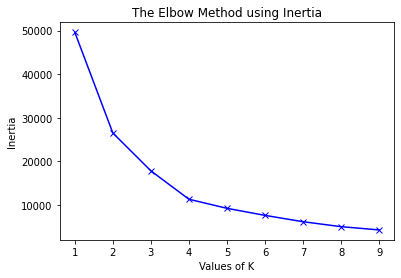

In [12]:
# Reading data and renaming columns
co2_data = pd.read_csv("co2_emission.csv")
flood_data = pd.read_csv("gfd_event_stats_20215_13_error_fixed_2.csv")
co2_data.rename(columns={'Annual CO₂ emissions (tonnes )':'Emission'} ,inplace=True)
flood_data['totalPopulation'] = flood_data['dfo_dead'] + flood_data['dfo_displaced']

def getCommons():
    country_list = np.unique(flood_data['dfo_country'])
    co2_country = np.unique(co2_data['Entity'])
    country_list.sort()
    co2_country.sort()
    common_countries = []
    count = 0
    for countryName in country_list:
        for country in co2_country:
            if(countryName == country):
                count = count + 1
                common_countries.append(countryName)
    return common_countries

def getTimeRange(countryName):
    split_list = []
    for info in flood_data[flood_data['dfo_country'] == countryName]['system:index']:
        splitted = info.split('_')
        split_list.append(splitted[-1][0:4])
    return (split_list[0] ,split_list[-1])
common_countries = getCommons()

def getTotalPop(countryName):
    return flood_data[flood_data['dfo_country'] == countryName]['totalPopulation'].sum()

def getCO2Pollution(dates ,countryName):
    countryData = co2_data[co2_data['Entity'] == countryName]
    times = list(np.arange(int(dates[0]) ,(int(dates[1])+1)))
    total = countryData[countryData['Year'].isin(times)]['Emission'].sum()
    return total

country_data_co2 = co2_data[ (co2_data['Entity'] == common_countries[0])]
country_data_flood = flood_data[ flood_data['dfo_country'] == common_countries[0] ]
country_data_flood = flood_data[['dfo_began' ,'dfo_ended' ,'totalPopulation']]

data = []
formatted_data = []
for countryName in common_countries:
    data.append([countryName ,getTotalPop(countryName) ,getCO2Pollution(getTimeRange(countryName) ,countryName)])

for row in data:
    formatted_data.append([float(row[1]),float(row[2])])

arr = np.array(formatted_data)
names = np.array(data)

d = {'Country Name' : names[:,0] ,'Total Population' :arr[:,0] ,'Emission' : arr[:,1]}
df = pd.DataFrame(data=d)
df['Ratio'] = 0 # df['Total Population'] / df['Emission'] 

df['Emission Group'] = 0
df['Population Group'] = 0
df = df.sort_values(by=['Emission'])
emission_indexes = df['Emission'].index
index = 0
for i in emission_indexes:
    df.at[emission_indexes[index] ,'Emission Group'] = index / 2
    index = index + 1

df = df.sort_values(by=['Total Population'])
pop_indexes = df['Emission'].index
index = 0
for i in pop_indexes:
    df.at[pop_indexes[index] ,'Population Group'] = index / 2
    index = index + 1

df = df.sort_values(by=['Total Population'])
ratio_indexes = df['Total Population'].index
index = 0
for i in ratio_indexes:
    df.at[ratio_indexes[index] ,'Ratio'] = index / 2
    index = index + 1


df.replace(np.inf ,0 ,inplace=True)

fig = px.scatter(df,x='Population Group',y='Emission Group',hover_data=['Country Name'])
fig.show()

kmeans_df = df[['Population Group','Emission Group']]
kmeans_df = kmeans_df.to_numpy()

# Using elbow method to find optimal cluster number.
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(kmeans_df)
    kmeanModel.fit(kmeans_df)
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(kmeans_df, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / kmeans_df.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

last_df = pd.DataFrame(df, columns = ['Population Group','Emission Group','Country Name','Ratio'])
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans = kmeans.fit(kmeans_df)

fig2 = px.scatter(last_df, x='Population Group',y='Emission Group', color=kmeans.labels_, 
                 hover_data=['Country Name'], template='ggplot2',size='Ratio')  
fig2.show()